# Explore cached dataset (main.py-style)
Load latest cached Parquet and visualize basics.

In [4]:
from pathlib import Path
import sys
import polars as pl

def find_project_root(start: Path = Path.cwd()) -> Path:
    # remonte jusqu'à trouver des marqueurs de la racine
    for p in [start, *start.parents]:
        if (p / "rte_challenge").exists() and (p / "scripts").exists():
            return p
    return start  # fallback si on ne trouve rien

ROOT = find_project_root()
sys.path.append(str(ROOT))  # pour import rte_challenge.*
cache_dir = ROOT / "data" / "cache"
cache_dir.mkdir(parents=True, exist_ok=True)

# essaie de charger le dernier cache ; sinon le génère
feats = sorted(cache_dir.glob("features_*.parquet"))
targs = sorted(cache_dir.glob("targets_*.parquet"))

if not (feats and targs):
    # pas de cache -> on génère un petit dataset
    from rte_challenge.data import generate_and_cache
    X, Y = generate_and_cache(cache_dir=str(cache_dir), episode_count=1, n_actions=20, force=False)
    feats = sorted(cache_dir.glob("features_*.parquet"))
    targs = sorted(cache_dir.glob("targets_*.parquet"))

fX = feats[-1]
fY = targs[-1]

X = pl.read_parquet(fX)
Y = pl.read_parquet(fY)
X.shape, Y.shape


((3808, 111), (3808, 101))

In [9]:
import numpy as np

n_obs, n_feat = X.shape
_, n_actions = Y.shape

finite_mask = np.isfinite(Y.to_numpy())
frac_finite = float(finite_mask.mean())

min_rho = pl.Series(np.nanmin(np.where(np.isfinite(Y.to_numpy()), Y.to_numpy(), np.inf), axis=1))
safe_rate = float((min_rho < 1.0).mean())

print(f"Observations: {n_obs} | Features: {n_feat} | Actions: {n_actions}")
print(f"Part des cibles finies (non-∞): {frac_finite:.3f}")
print(f"Etat 'sécure' atteignable (min rho < 1): {safe_rate:.3f}")


Observations: 3808 | Features: 111 | Actions: 101
Part des cibles finies (non-∞): 0.812
Etat 'sécure' atteignable (min rho < 1): 0.999


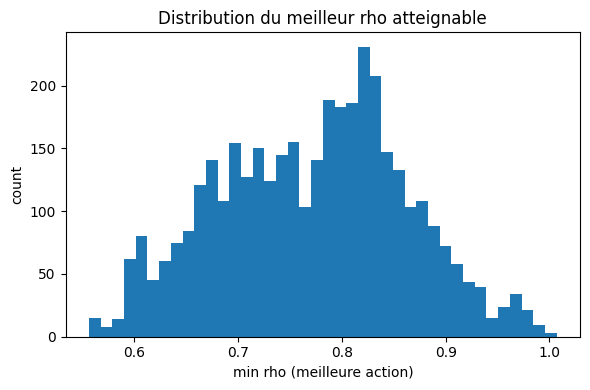

In [10]:
import matplotlib.pyplot as plt
min_rho_np = min_rho.to_numpy()
plt.figure(figsize=(6,4))
plt.hist(min_rho_np[np.isfinite(min_rho_np)], bins=40)
plt.xlabel("min rho (meilleure action)")
plt.ylabel("count")
plt.title("Distribution du meilleur rho atteignable")
plt.tight_layout()
plt.show()


In [5]:
X.head(3)

gen_p_0,gen_p_1,gen_p_2,gen_p_3,gen_p_4,gen_p_5,gen_q_0,gen_q_1,gen_q_2,gen_q_3,gen_q_4,gen_q_5,load_p_0,load_p_1,load_p_2,load_p_3,load_p_4,load_p_5,load_p_6,load_p_7,load_p_8,load_p_9,load_p_10,load_q_0,load_q_1,load_q_2,load_q_3,load_q_4,load_q_5,load_q_6,load_q_7,load_q_8,load_q_9,load_q_10,topo_0,topo_1,topo_2,…,topo_40,topo_41,topo_42,topo_43,topo_44,topo_45,topo_46,topo_47,topo_48,topo_49,topo_50,topo_51,topo_52,topo_53,topo_54,topo_55,topo_56,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
81.400002,79.300003,5.3,0.0,0.0,82.246674,19.496038,71.340233,24.368923,24.368923,24.01807,-17.27466,21.9,85.800003,44.299999,6.9,11.9,28.5,8.8,3.5,5.4,12.6,14.4,15.4,59.700001,30.799999,4.8,8.3,19.4,6.1,2.4,3.9,8.8,10.5,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.34013,0.360423,0.272101,0.267226,0.828129,0.269201,0.343346,0.531516,0.495164,0.731675,0.288539,0.382659,0.289275,0.431878,0.396449,0.544602,0.533467,0.924473,0.453396,0.46154
82.5,80.699997,5.3,0.0,0.0,80.113495,19.162947,71.243042,24.402109,24.402109,24.112627,-16.656225,22.0,85.699997,44.900002,6.8,11.7,28.1,8.8,3.4,5.4,12.9,14.7,15.4,60.0,30.9,4.8,8.2,19.700001,6.1,2.5,3.8,8.9,10.3,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.326746,0.356591,0.263959,0.267204,0.829614,0.278238,0.340316,0.533229,0.496741,0.738767,0.290505,0.390571,0.29017,0.447009,0.396498,0.54363,0.531994,0.925324,0.455181,0.46067
82.699997,81.599998,5.4,0.0,0.0,79.293762,19.233862,72.06739,24.604052,24.604052,24.333878,-16.379263,22.0,86.300003,44.799999,7.0,11.7,28.0,8.8,3.5,5.5,12.4,14.8,15.4,60.799999,31.200001,4.9,8.3,20.0,6.3,2.4,3.8,8.9,10.5,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.322066,0.354571,0.26173,0.266428,0.828156,0.280012,0.337524,0.53956,0.498101,0.73516,0.289035,0.389768,0.296073,0.438327,0.405533,0.54143,0.529341,0.920692,0.459357,0.460031


In [6]:
Y.head(3)

rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,…,rho_64,rho_65,rho_66,rho_67,rho_68,rho_69,rho_70,rho_71,rho_72,rho_73,rho_74,rho_75,rho_76,rho_77,rho_78,rho_79,rho_80,rho_81,rho_82,rho_83,rho_84,rho_85,rho_86,rho_87,rho_88,rho_89,rho_90,rho_91,rho_92,rho_93,rho_94,rho_95,rho_96,rho_97,rho_98,rho_99,rho_100
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.969826,inf,0.924672,0.957245,1.910263,1.910263,1.381103,1.252364,1.672045,0.924473,0.922037,0.927189,1.252364,0.872539,0.957247,0.924183,inf,1.223919,0.924473,1.223919,1.280081,1.18201,2.921079,inf,0.924848,inf,0.924473,0.861882,1.252364,0.919581,0.921586,0.924473,1.043278,inf,0.922617,inf,inf,…,0.92462,0.924773,1.280081,1.252364,1.18201,0.923487,1.223919,0.924473,inf,inf,0.924473,1.18201,0.924357,1.022155,0.922835,inf,inf,0.951399,0.922458,1.07932,0.924473,0.922037,0.861882,0.927413,0.924473,inf,1.280081,0.92432,0.923873,0.924261,0.924473,inf,0.924473,inf,inf,1.07932,0.924473
0.97747,inf,0.925521,0.956519,1.913983,1.913983,1.383613,1.252578,1.698486,0.925324,0.922793,0.928029,1.252578,0.873741,0.95652,0.925035,inf,1.223866,0.925324,1.223866,1.276919,1.171698,2.963777,inf,0.925697,inf,0.925324,0.862217,1.252578,0.920567,0.922447,0.925324,1.043774,inf,0.923474,inf,inf,…,0.92547,0.925622,1.276919,1.252578,1.171698,0.924341,1.223866,0.925324,inf,inf,0.925324,1.171698,0.925208,1.017343,0.923691,inf,inf,0.950245,0.923316,1.078207,0.925324,0.922793,0.862217,0.928253,0.925324,inf,1.276919,0.925171,0.924726,0.925113,0.925324,inf,0.925324,inf,inf,1.078207,0.925324
0.976906,inf,0.920889,0.95134,1.904173,1.904173,1.402161,1.247549,1.686175,0.920692,0.918325,0.923393,1.247549,0.869084,0.951342,0.920403,inf,1.218037,0.920692,1.218037,1.272976,1.186538,2.937955,inf,0.921065,inf,0.920692,0.856194,1.247549,0.916391,0.91782,0.920692,1.038728,inf,0.918846,inf,inf,…,0.920838,0.92099,1.272976,1.247549,1.186538,0.91971,1.218037,0.920692,inf,inf,0.920692,1.186538,0.920576,1.014091,0.919062,inf,inf,0.960046,0.918687,1.0716,0.920692,0.918325,0.856194,0.923616,0.920692,inf,1.272976,0.920539,0.920095,0.920481,0.920692,inf,0.920692,inf,inf,1.0716,0.920692


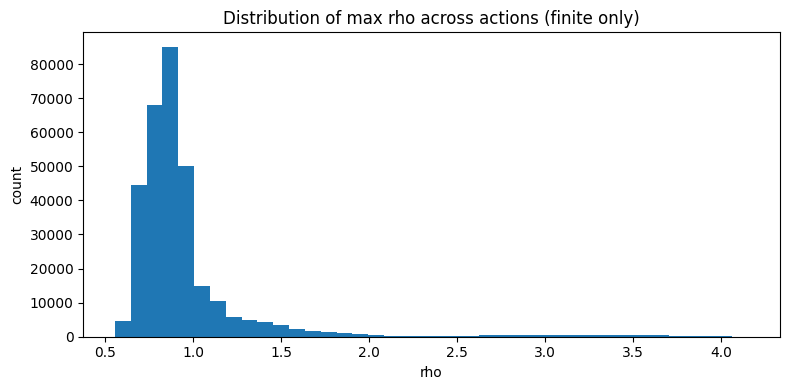

In [7]:
import matplotlib.pyplot as plt
from rte_challenge.viz import plot_targets_hist
fig = plot_targets_hist(Y)
plt.show()

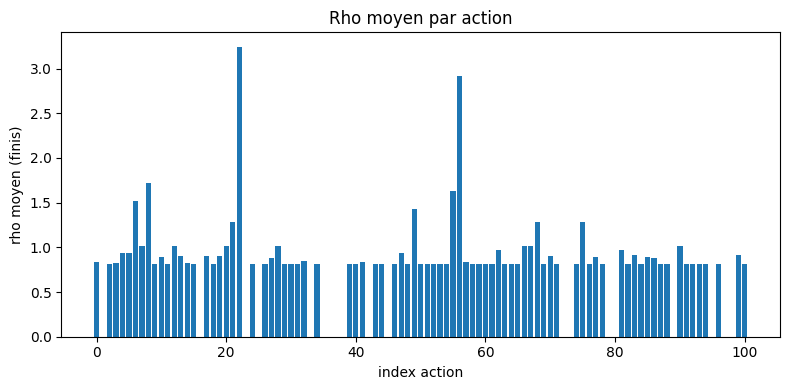

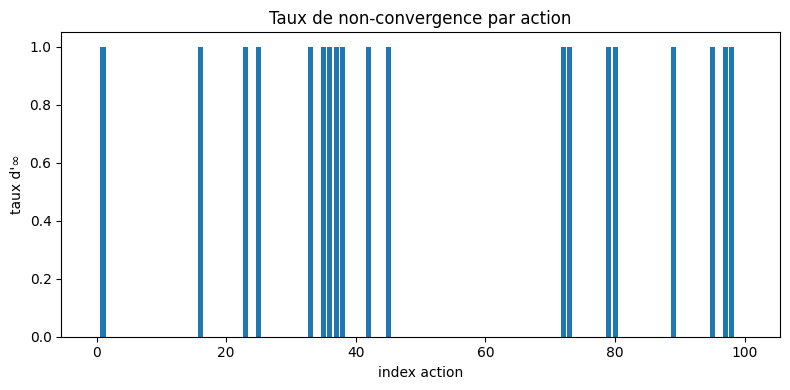

In [12]:
import numpy as np

Ynp = Y.to_numpy()
is_finite = np.isfinite(Ynp)
mean_rho_per_action = np.where(is_finite, Ynp, np.nan).mean(axis=0)
inf_rate_per_action = (~is_finite).mean(axis=0)

# Bar plot moyennes
plt.figure(figsize=(8,4))
plt.bar(range(Y.shape[1]), mean_rho_per_action)
plt.xlabel("index action")
plt.ylabel("rho moyen (finis)")
plt.title("Rho moyen par action")
plt.tight_layout()
plt.show()

# Bar plot taux d'infini
plt.figure(figsize=(8,4))
plt.bar(range(Y.shape[1]), inf_rate_per_action)
plt.xlabel("index action")
plt.ylabel("taux d'∞")
plt.title("Taux de non-convergence par action")
plt.tight_layout()
plt.show()


c:\Users\flobm\Documents\Premier_job\rte_projet\.venv\Lib\site-packages\matplotlib\transforms.py:2455: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


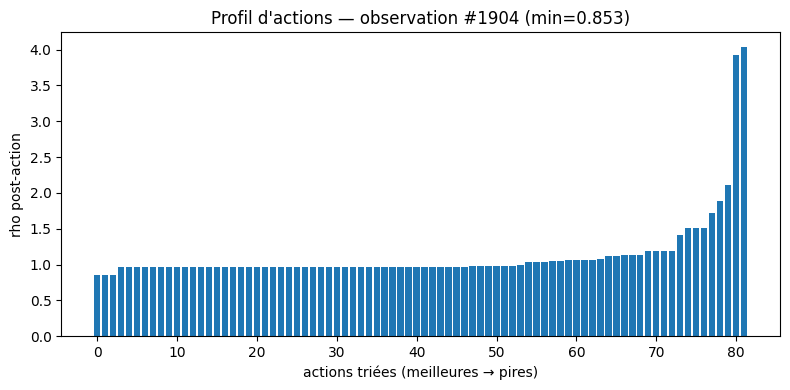

In [14]:
import numpy as np

obs_idx = int(n_obs * 0.5)  # milieu; change librement
vals = Ynp[obs_idx].copy()
order = np.argsort(vals)
sorted_vals = vals[order]

plt.figure(figsize=(8,4))
plt.bar(range(len(sorted_vals)), sorted_vals)
plt.xlabel("actions triées (meilleures → pires)")
plt.ylabel("rho post-action")
plt.title(f"Profil d'actions — observation #{obs_idx} (min={np.min(vals):.3f})")
plt.tight_layout()
plt.show()



In [15]:
import json

key = fY.name.replace("targets_", "").replace(".parquet","")
act_file = (cache_dir / f"actions_{key}.json")
if act_file.exists():
    acts = json.loads(act_file.read_text(encoding="utf-8"))
    # top-5 meilleures et pires pour une observation
    k = 5
    best_idx = order[:k]
    worst_idx = order[-k:]
    print("Top actions (repr):")
    for j in best_idx:
        print(f"  #{j}: {acts[j]['repr']}")
    print("\nWorst actions (repr):")
    for j in worst_idx:
        print(f"  #{j}: {acts[j]['repr']}")
else:
    print("Pas de fichier actions_<clé>.json trouvé.")


Top actions (repr):
  #5: This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([17])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
  #4: This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([17])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
  #47: This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([17])
	 - NOT switch anything in the topology
	 - NOT force any particula

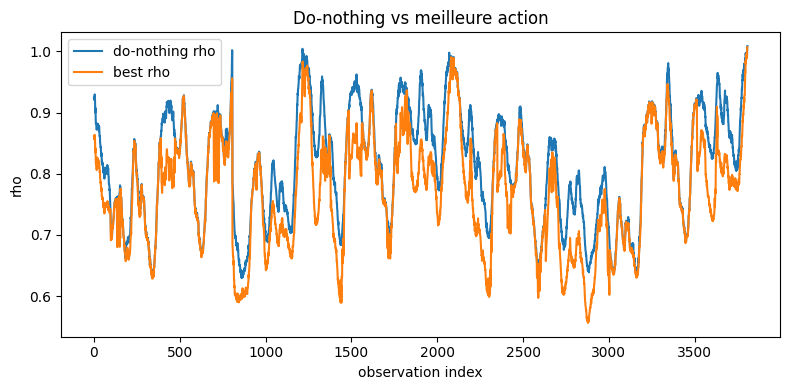

In [16]:
import re, json, numpy as np

def guess_do_nothing_index(cache_dir, fY):
    key = fY.name.replace("targets_", "").replace(".parquet","")
    j = None
    act_file = cache_dir / f"actions_{key}.json"
    if act_file.exists():
        acts = json.loads(act_file.read_text(encoding="utf-8"))
        for a in acts:
            if "DoNothing" in a["repr"] or "do_nothing" in a["repr"].lower():
                j = a["index"]; break
    return j if j is not None else Y.shape[1]-1

j0 = guess_do_nothing_index(cache_dir, fY)
do_nothing = Ynp[:, j0]
best = np.nanmin(np.where(np.isfinite(Ynp), Ynp, np.inf), axis=1)

plt.figure(figsize=(8,4))
plt.plot(do_nothing, label="do-nothing rho")
plt.plot(best, label="best rho")
plt.xlabel("observation index")
plt.ylabel("rho")
plt.title("Do-nothing vs meilleure action")
plt.legend()
plt.tight_layout()
plt.show()


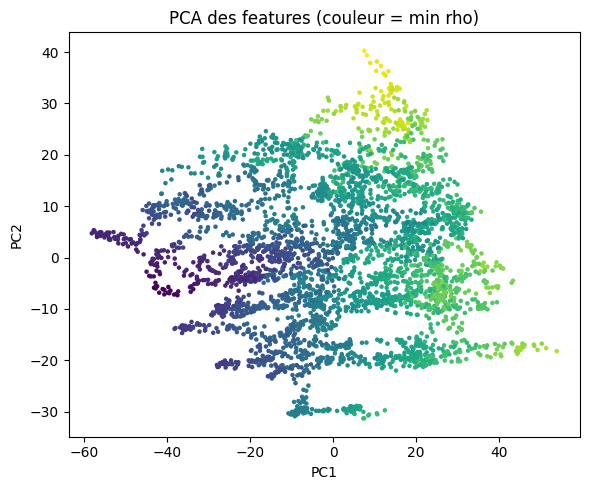

In [18]:
from sklearn.decomposition import PCA
import numpy as np
Xp = X.to_numpy()
mr = min_rho_np

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xp)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], s=5, c=mr)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA des features (couleur = min rho)")
plt.tight_layout()
plt.show()



c:\Users\flobm\Documents\Premier_job\rte_projet\.venv\Lib\site-packages\matplotlib\transforms.py:2455: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


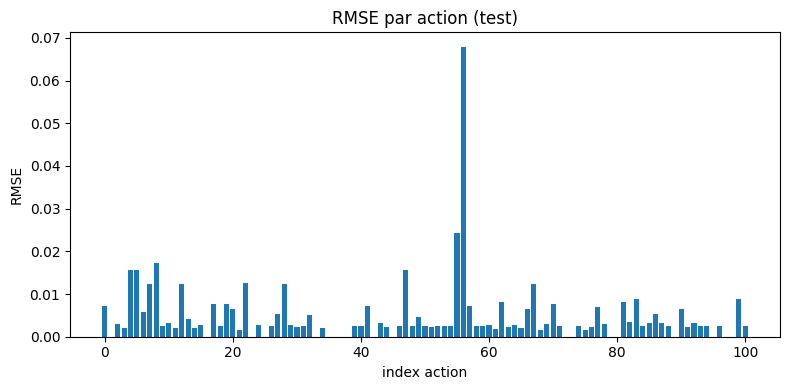

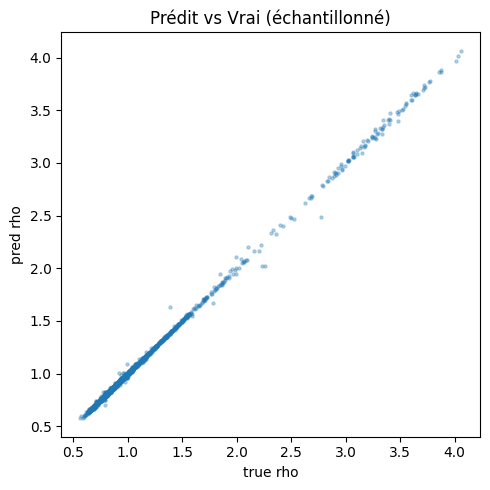

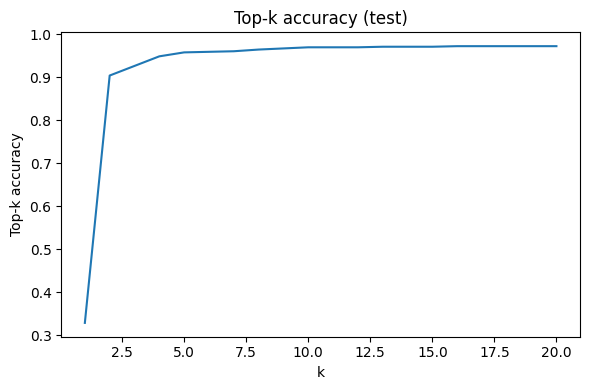

In [19]:
import numpy as np
proc = ROOT / "data" / "processed"
yt = proc / "Y_test.npy"
yp = proc / "Y_pred.npy"
if yt.exists() and yp.exists():
    Yt = np.load(yt); Yp = np.load(yp)

    # a) RMSE par action (barres)
    rmse_per_action = np.sqrt(np.mean((Yt - Yp) ** 2, axis=0))
    plt.figure(figsize=(8,4))
    plt.bar(range(rmse_per_action.size), rmse_per_action)
    plt.xlabel("index action"); plt.ylabel("RMSE")
    plt.title("RMSE par action (test)")
    plt.tight_layout(); plt.show()

    # b) Scatter préd. vs vrai (échantillon)
    yt_flat = Yt.ravel(); yp_flat = Yp.ravel()
    idx = np.random.default_rng(0).choice(yt_flat.size, size=min(5000, yt_flat.size), replace=False)
    plt.figure(figsize=(5,5))
    plt.scatter(yt_flat[idx], yp_flat[idx], s=5, alpha=0.3)
    plt.xlabel("true rho"); plt.ylabel("pred rho")
    plt.title("Prédit vs Vrai (échantillonné)")
    plt.tight_layout(); plt.show()

    # c) Top-k accuracy curve
    true_rank = np.argsort(Yt, axis=1)
    # rang préd (argmin)
    pred_best = np.argmin(Yp, axis=1)
    # courbe k -> top-k acc
    ks = np.arange(1, min(20, Yt.shape[1]) + 1)
    accs = []
    for k in ks:
        hits = [(pred_best[i] in true_rank[i,:k]) for i in range(Yt.shape[0])]
        accs.append(np.mean(hits))
    plt.figure(figsize=(6,4))
    plt.plot(ks, accs)
    plt.xlabel("k"); plt.ylabel("Top-k accuracy")
    plt.title("Top-k accuracy (test)")
    plt.tight_layout(); plt.show()

else:
    print("Pas de prédictions (Y_test/Y_pred) trouvées dans data/processed.")
